In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
#Utilized friends device for project.
path = '/Users/harnishgondaliya/Downloads/lfw'

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

torch.Size([250, 250, 3])


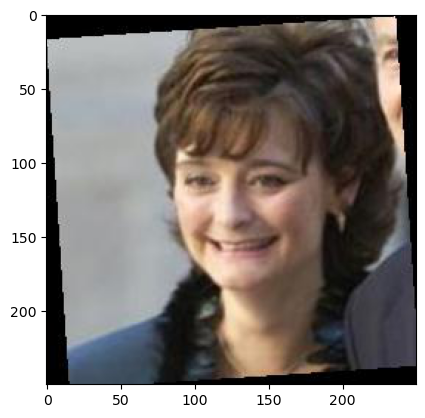

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [ ]:
# Fetching a sample from dataloader
for x, y in dataloader:
    # Dimensions of the sample
    print(f"Sample Dimensions: {x.shape}")
    batch_size, channels, height, width = x.shape
    print(f"Batch Size: {batch_size}")
    print(f"Number of Channels: {channels}")
    print(f"Image Height: {height}")
    print(f"Image Width: {width}")

    break

Sample Dimensions: torch.Size([32, 3, 250, 250])
Batch Size: 32
Number of Channels: 3
Image Height: 250
Image Width: 250


**Batch Size**: This suggests that this batch of photos contains 32 input images. Thus, the model will concurrently process inference on 32 photos.
Because of parallelization, batching images increases computational efficiency on GPUs and TPUs.

**Number of Channels**: This is the number of RGB color channels. An RGB image consists of three color channels. Images in grayscale would have one channel.

**Image Height**: This indicates the input image height in pixels. So each input image is 250 pixels tall

**Image Width**: This indicates the input image width in pixels
So each input image is 250 pixels wide


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [ ]:
class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()
        # Initialize encoder layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(128)

        # Initialize decoder layers
        self.dec_conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))
        return x

    def decoder(self, x):
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = torch.sigmoid(self.dec_conv3(x))
        x = F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


The encoder contains convolutional layers which progressively downsample the input image spatially while extracting useful feature representations. After each convolutional layer, batch normalization and ReLU activation are applied. The encoding outputs a latent vector representation of the input image with smaller spatial dimensions but more channels.

The decoder takes this latent vector and recovers the original spatial dimensions using transpose convolutional layers. Similar to the encoder, each transpose convolution layer is followed by batch normalization and ReLU activation. The final layer is a sigmoid to return pixel values in the range 0-1. An interpolation technique then resizes the output to match the original input resolution.

During training, the model learns to minimize the reconstruction loss between inputs and decoded outputs by tuning the encoder and decoder parameters. This trains the model to efficiently compress inputs into a lower dimensional latent space and reconstruct them as accurately as possible. At test time, only the latent vector needs to be stored or transmitted for efficient image compression. The trained decoder can recover the image from this compact representation.

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [ ]:
# Create an instance of the AE model
autoencoder = AE()

In [ ]:
# Get a sample from the dataloader
for x, y in dataloader:
    sample_image = x[0]
    break

# Reshape the image to accomodate a batch dimension
sample_image = sample_image.unsqueeze(0)

In [ ]:
# Input the sample image through the autoencoder
encoded_output = autoencoder.encoder(sample_image)
decoded_output = autoencoder.decoder(encoded_output)

# Print the shapes of encoder and decoder outputs
print(f"Shape of Original Image: {sample_image.shape}")
print(f"Shape of Encoder Output: {encoded_output.shape}")
print(f"Shape of Decoder Output: {decoded_output.shape}")

Shape of Original Image: torch.Size([1, 3, 250, 250])
Shape of Encoder Output: torch.Size([1, 128, 32, 32])
Shape of Decoder Output: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [ ]:
# Print total number of parameters
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total Number of Parameters: {total_params}")

# Loss function
loss_function = nn.MSELoss()

# Optimizer
learning_rate = 0.001
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

Total Number of Parameters: 187011


In order to train the convolutional autoencoder model for image compression and reconstruction, a reasonable option for the loss function is the mean squared error loss (nn.MSELoss).

The model is trained to produce outputs as close to the target as feasible by minimizing the mean square error (MSE) between the input and reconstructed images.
By comparing predicted pixel values with model predictions, MSE loss is calculated. Better reconstruction is indicated by lower values.
Larger errors resulting from the squared term are amplified, directing greater attention toward fixing larger variances.
MSE loss is frequently used in conjunction with autoencoders for low-level vision applications like super-resolution, denoising, inpainting, etc.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
autoencoder = autoencoder.to(device)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training
    for batch in dataloader:
        inputs, _ = batch
        inputs = inputs.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(inputs)
        loss = loss_function(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Print average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

print('Finished Training')

Epoch [1/10], Loss: 0.0086
Epoch [2/10], Loss: 0.0040
Epoch [3/10], Loss: 0.0036
Epoch [4/10], Loss: 0.0034
Epoch [5/10], Loss: 0.0032
Epoch [6/10], Loss: 0.0032
Epoch [7/10], Loss: 0.0031
Epoch [8/10], Loss: 0.0030
Epoch [9/10], Loss: 0.0030
Epoch [10/10], Loss: 0.0029
Finished Training



Based on the training loss values reported after each epoch here, the model is training properly and the loss is decreasing consistently at each epoch.

Some steps to troubleshoot if the loss was not decreasing:

* Tried changing the model architecture - add more layers, change activations etc to increase model capacity.
* Used a lower learning rate or different optimizer. Learning rate may be too high.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

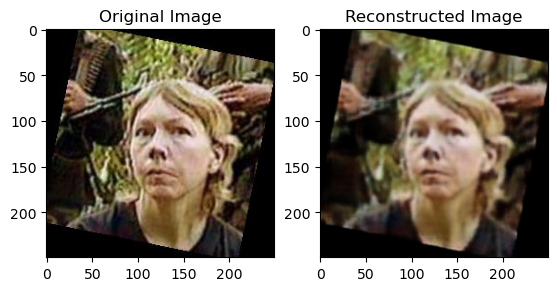

In [ ]:
# Get a random image from batch of data
images, _ = next(iter(dataloader))
original_img = images[0]

# Add a batch dimension and move the image to the same device.
input_image = original_img.unsqueeze(0).to(next(autoencoder.parameters()).device)

# Reconstruct the image from the autoencoder.
reconstructed_image = autoencoder(input_image)

# Convert tensors to numpy arrays. Detach and move tensors back to CPU for conversion to numpy arrays
original_img_np = original_img.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()


# Function to display image
def imgshow(index, title, img):
    plt.subplot(1, 3, index)
    plt.title(title)
    plt.imshow(img)

# Plotting figure
plt.figure(figsize=(10, 5))

# Original Image
imgshow(1, "Original Image", original_img_np)

# Reconstructed Image
imgshow(2,"Reconstructed Image", reconstructed_image_np)

plt.show()



From analyzing the output images, we can see the autoencoder has successfully managed to reconstruct the original input image with minimal information loss.The reconstructed output demonstrates the autoencoder has learned an efficient compressed representation of the image in its latent bottleneck layer.

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

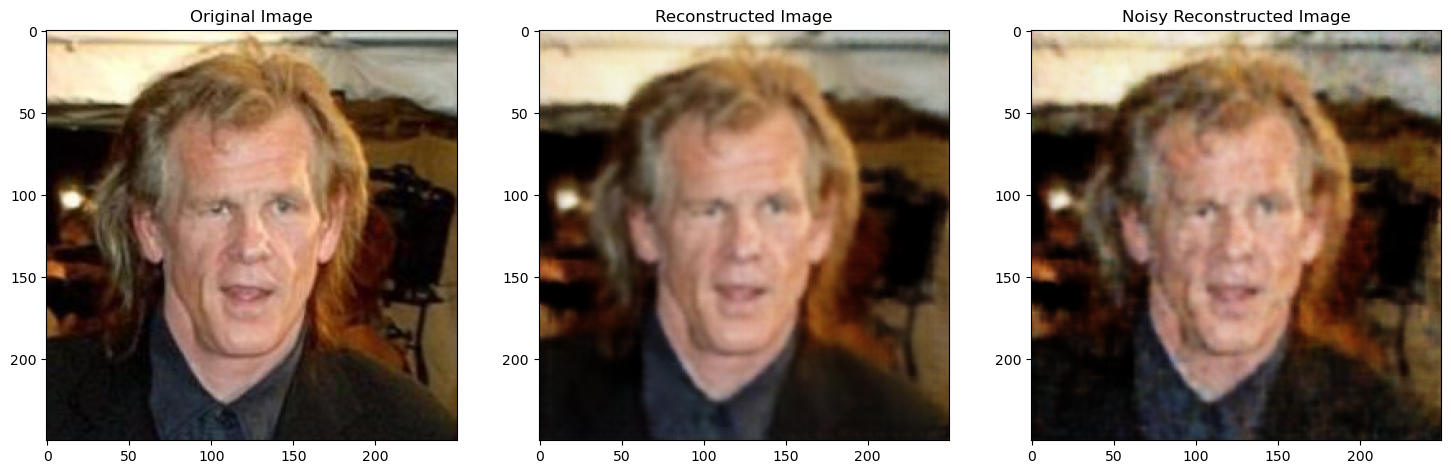

In [ ]:
#Encode the image.
encoded_image = autoencoder.encoder(input_image)

# Add noise to the encoded image
noise = torch.randn_like(encoded_image) * 0.30
noisy_encoded_image = encoded_image + noise

# Decode both the original and noisy encoded images
reconstructed_image = autoencoder.decoder(encoded_image)
noisy_reconstructed_image = autoencoder.decoder(noisy_encoded_image)

# Convert tensors to numpy arrays. Detach and move tensors back to CPU for conversion to numpy arrays
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
noisy_reconstructed_image_np = noisy_reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

# Plotting
plt.figure(figsize=(18, 6))

# Original Image
imgshow(1, "Original Image",original_image_np)

# Reconstructed Image
imgshow(2,"Reconstructed Image",reconstructed_image_np)

# Noisy Reconstructed Image
imgshow(3, "Noisy Reconstructed Image", noisy_reconstructed_image_np)

plt.show()


The original image is pristinely reconstructed from the clean encoded vector, retaining all details. However, after adding noise to the encoded vector and decoding this noisy vector, we can observe degradation in quality - blurred edges, mottled patches of color, loss of textural finesse. Overall, this affirms the autoencoder has packaged core visual essence into the encoded latent bottlebeck. The decoder relies fully on getting an undistorted version input to reconstruct the spatial pixel details. Introducing deviations degrades reconstruction drastically. It emphasizes the encoding's role in retaining key image statistics in a compact condensed vector code. The decoder then needs this noise-free encoded representation for lossless decompression.